In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
df = pd.read_csv('../03-classification/bank-full.csv', delimiter=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no



### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [6]:
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

df = df[columns]
df

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


In [ ]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.y == 'yes').values
y_val = (df_val.y == 'yes').values
y_test = (df_test.y == 'yes').values


del df_train['y']
del df_val['y']
del df_test['y']


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [16]:
df_train.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

In [32]:
from sklearn.metrics import roc_auc_score
numericals = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

aucs = []


for feature in numericals:
    score = roc_auc_score(y_train, df_train[feature].values)
    if score < 0:
        score = roc_auc_score(y_train, -df_train[feature].values)
    aucs.append((feature, round(float(score),3)))

aucs

[('age', 0.488),
 ('balance', 0.589),
 ('day', 0.474),
 ('duration', 0.815),
 ('campaign', 0.429),
 ('pdays', 0.59),
 ('previous', 0.599)]

Here the variable with the highest AUC is `duration`

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [40]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict_proba(X_val)[:, 1]

float(roc_auc_score(y_val, y_pred))

0.9004060986101251

The correct answer is number 3, 0.89

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

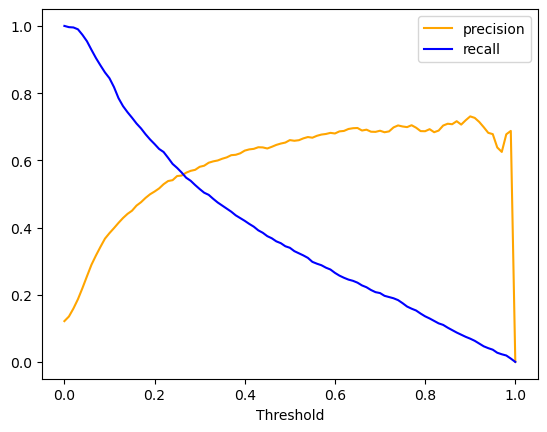

In [81]:

threshold = np.linspace(0, 1, 101)
precision = []
recall = []

for thr in threshold:
    tp = ((y_val == True) & (y_pred >= thr)).sum()
    tn = ((y_val == False) & (y_pred < thr)).sum()
    fp = ((y_val == False) & (y_pred >= thr)).sum()
    fn = ((y_val == True) & (y_pred < thr)).sum()

    if (tp + fp) == 0:
        pre = 0
    else:
        pre = tp / (tp + fp)
    
    rec = tp / (tp + fn)

    if (pre == rec) & (thr != 1):
        print(thr)


    precision.append(pre)

    recall.append(rec)


plt.plot(threshold, precision, label='precision', color='orange')
plt.plot(threshold, recall, label='recall', color='blue')
plt.xlabel('Threshold')
plt.legend()
plt.show()



From the graph we can see that the curves intersect at 0.265. 

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

/tmp/ipykernel_336947/4246765106.py:12: RuntimeWarning: invalid value encountered in divide
  2 * (precision * recall) / (precision + recall),


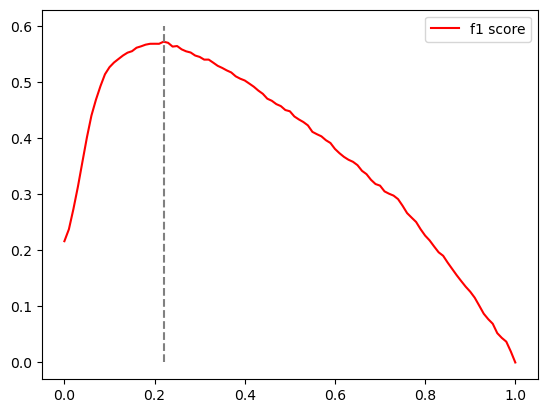

In [97]:
precision = np.array(precision, dtype=float)
recall    = np.array(recall,    dtype=float)

# Replace any NaN with 0.0
precision = np.nan_to_num(precision, nan=0.0)
recall    = np.nan_to_num(recall,    nan=0.0)


# Now you know precision+recall is either >0 or ==0
f1 = np.where(
    (precision + recall) != 0,
    2 * (precision * recall) / (precision + recall),
    0.0
)


plt.plot(threshold, f1, label='f1 score', color='red')
plt.vlines(0.22, 0, 0.6, color='gray', linestyle='--')
plt.legend()
plt.show()

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [112]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_train = (df_train.y == 'yes').values  
    y_val = (df_val.y == 'yes').values

    del df_train['y']
    del df_val['y']

    train_dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)

    val_dicts = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]

    scores.append(roc_auc_score(y_val, y_pred))

print(f'{np.mean(scores):.3f} +- {np.std(scores):.3f}')
    


0.906 +- 0.005


The answer is 0.006


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [114]:
C = [0.000001, 0.001, 1]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for c in C:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        df_train = df_train.reset_index(drop=True)
        df_val = df_val.reset_index(drop=True)

        y_train = (df_train.y == 'yes').values  
        y_val = (df_val.y == 'yes').values

        del df_train['y']
        del df_val['y']

        train_dicts = df_train.to_dict(orient='records')
        dv = DictVectorizer()
        X_train = dv.fit_transform(train_dicts)

        val_dicts = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dicts)

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]

        scores.append(roc_auc_score(y_val, y_pred))

    print(f'{c} -> {np.mean(scores):.3f} +- {np.std(scores):.3f}')


1e-06 -> 0.701 +- 0.009
0.001 -> 0.861 +- 0.007
1 -> 0.906 +- 0.005


C = 1 leads to the best AUC mean score across the folds